In [78]:
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END, MessagesState
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.language_models import BaseChatModel
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

# Import a chat model (replace with your preferred model)
from langchain_groq import ChatGroq
from dotenv import load_dotenv

load_dotenv()

True

In [79]:
# Define the state
class AssistantState(MessagesState):
    task_decision: str
    database_info: str


def query_database(query: str) -> dict:
    return {"database_result": "The User's name is Chris."}


def get_chat_model() -> BaseChatModel:
    return ChatGroq(model="llama-3.1-70b-versatile")


# Node functions
def main_conversation(state: AssistantState) -> AssistantState:
    chat = get_chat_model()
    prompt = ChatPromptTemplate.from_messages([
        ("system",
         "You are a helpful assistant for a student. Respond based on the conversation and any database information."),
        ("human", "{input}"),
        ("ai", "Database info: {database_info}\nResponse:"),
    ])
    chain = prompt | chat
    response = chain.invoke({"input": state["messages"][-1].content,
                             "database_info": state.get("database_info", "No database info available.")})
    return {"messages": [AIMessage(content=response.content)]}


def task_planning(state: AssistantState) -> AssistantState:
    chat = get_chat_model()
    prompt = ChatPromptTemplate.from_messages([
        ("system",
         "You can ask queries to a Database Agent in Natural Language. Decide if you want ask queries to the DataBase Agent is needed or if we can respond directly. Output 'query' or 'respond'."),
        ("human", "{input}"),
    ])
    chain = prompt | chat
    decision = chain.invoke({"input": state["messages"][-1].content})
    print(f"{decision.content.strip().lower()=}")
    return {"task_decision": decision.content.strip().lower()}


def database_query(state: AssistantState) -> AssistantState:
    chat = get_chat_model()
    prompt = ChatPromptTemplate.from_messages([
        ("system",
         "Formulate a query based on the question in NATURAL LANGUAGE. The query will be sent to the database agent."),
        ("human", "{input}"),
    ])

    chain = (prompt | chat)
    result = chain.invoke({"input": state["messages"][-1].content})
    print(f"{result=}")
    return {"database_info": query_database(result)}

In [80]:
# Create the graph
workflow = StateGraph(AssistantState)

# Add nodes
workflow.add_node("main_conversation", main_conversation)
workflow.add_node("task_planning", task_planning)
workflow.add_node("database_query", database_query)

# Add edges
workflow.set_entry_point("task_planning")
workflow.add_conditional_edges(
    "task_planning",
    lambda x: "database_query" if x["task_decision"] == "query" else "main_conversation",
    {
        "database_query": "database_query",
        "main_conversation": "main_conversation",
    }
)
workflow.add_edge("database_query", "main_conversation")
workflow.add_edge("main_conversation", END)

# Compile the graph
app = workflow.compile()

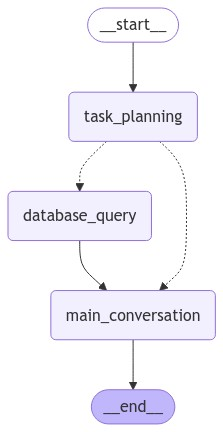

In [81]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [82]:

# Example usage
messages = [HumanMessage(content="What is my Name? Get information from the database.")]
result = app.invoke({"messages": messages})
print("\n\nFinal result:")
print(result['messages'][-1].content)

decision.content.strip().lower()='query'
content="Here's a possible query based on the question:\n\n`SELECT name FROM users WHERE user_id = [current_user_id]`\n\nThis query assumes that there is a table called 'users' in the database with a column called 'name', and that the current user's ID is stored in the variable 'current_user_id'. The database agent can then execute this query to retrieve the user's name from the database." response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 69, 'total_tokens': 152, 'completion_time': 0.332, 'prompt_time': 0.027866453, 'queue_time': 0.090586046, 'total_time': 0.359866453}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_b6828be2c9', 'finish_reason': 'stop', 'logprobs': None} id='run-d93e1cd9-99e5-41e1-9548-32458a86444f-0' usage_metadata={'input_tokens': 69, 'output_tokens': 83, 'total_tokens': 152}


Final result:
 Your name is Chris.
